# <center> Predicting Forest Cover Types </center>

## Introduction

This notebook is to process data provided by PrecisionGx for their technical assignment. The aim will be to predict between these two types of forest covers:
* Spruce/Fir = 0
* Lodgepole Pine = 1'

Because there are only two labels, they have been stored in binary format as shown above. We were also given the following information:
* "We have collapsed the original 40 binary columns for soil type down to one column Soil_Type"
* "We have collapsed the original 4 binary columns for wilderness area down to one column Wilderness_Area"

Quickly glancing through the the original data source, we find the following regarding the size of the data set and the original features:
* Number of instances (observations):  581,012
* Number of Attributes:	12 measures, but 54 columns of data (10 quantitative variables, 4 binary wilderness areas and 40 binary soil type variables)

**In summary, this seems to be a supervised classification problem having binary output, with both continuous and categorical input features.**

# Import packages/libraries

In [76]:
# General processing
import numpy as np
import pandas as pd

# Load Data into SQLite3
!pip install sqlalchemy
import sqlalchemy as sa

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Modeling given that it is a supervised classification problem
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# metrics are used to find accuracy or error
from sklearn import metrics 
from sklearn.metrics import plot_confusion_matrix

# Loading data

## Load train_data.csv onto a sqlite database

In [8]:
# Load data from a flat file into a sqlite database

def load_csv_to_sql(file_path, database='data.db', tablename='ForestCoverage'):
    #Function definition to convert csv into SQLite3
    data = pd.read_csv(file_path)
    engine = sa.create_engine(f'sqlite:///{database}')
    data.to_sql(tablename, engine, index=False)

# TODO: Fill in path to train_data.csv
file_path = './data/train_data.csv'
load_csv_to_sql(file_path)

## Read data into a dataframe from the sqlite database
Read Data from SQLite3 using sqlalchemy and pandas

In [14]:
# Create a function called "load_data" to take in the database and table name, and return a pandas dataframe
def load_data(database, tablename):
    engine = sa.create_engine("sqlite:///%s" % database, execution_options={"sqlite_raw_colnames": True})
    df = pd.read_sql_table(tablename, engine)
    return df

In [15]:
# Call the load_data function to obtain our initial data stored in a dataframe: raw_data
raw_df = load_data(database='data.db', tablename='ForestCoverage')
raw_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology.1,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Label,Soil_Type,Wilderness_Area
0,2804,139,9,268,65,3180,234,238,135,6121,1,Soil_Type11,Wilderness_Area0
1,2785,155,18,242,118,3090,238,238,122,6211,1,Soil_Type29,Wilderness_Area0
2,2579,132,6,300,-15,67,230,237,140,6031,1,Soil_Type28,Wilderness_Area0
3,2886,151,11,371,26,5253,234,240,136,4051,1,Soil_Type29,Wilderness_Area0
4,2742,134,22,150,69,3215,248,224,92,6091,1,Soil_Type29,Wilderness_Area0


# Exploratory data analysis
Now that we have our data loaded in the format desired, we can start exploring our fields to get initial insights. First, let's take a look globally at all the features.

In [16]:
# First look at features to understand features, their types, size of dataframe, and whether we have null data
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326793 entries, 0 to 326792
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Elevation                           326793 non-null  int64 
 1   Aspect                              326793 non-null  int64 
 2   Slope                               326793 non-null  int64 
 3   Horizontal_Distance_To_Hydrology    326793 non-null  int64 
 4   Vertical_Distance_To_Hydrology      326793 non-null  int64 
 5   Horizontal_Distance_To_Hydrology.1  326793 non-null  int64 
 6   Hillshade_9am                       326793 non-null  int64 
 7   Hillshade_Noon                      326793 non-null  int64 
 8   Hillshade_3pm                       326793 non-null  int64 
 9   Horizontal_Distance_To_Fire_Points  326793 non-null  int64 
 10  Label                               326793 non-null  int64 
 11  Soil_Type                           326

It appears that we do not have null data, but let's double-check.

In [17]:
raw_df.isna().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Hydrology.1    0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Label                                 0
Soil_Type                             0
Wilderness_Area                       0
dtype: int64

Great, we have confirmed that we have no null values! But we notice that there is one suspicious field "Horizontal_Distance_To_Hydrology.1". The nomenclature indicates that this field was accidentally doubled up. Let's explore to find out.

In [19]:
raw_df[["Horizontal_Distance_To_Hydrology", "Horizontal_Distance_To_Hydrology.1"]].sample(10)

,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology.1
185305,108,4473
129706,60,1440
309770,569,1899
307816,42,2346
137624,433,3062
173530,42,2781
240686,342,1455
277347,108,446
28438,67,4672
122115,404,1677


The columns are not doubled, so we cross-check with the original data documentation and find that there is indeed only one intended field. In order to decide which one to drop, we can check against `Vertical_Distance_To_Hydrology`

In [20]:
raw_df[["Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Hydrology", "Horizontal_Distance_To_Hydrology.1"]].sample(10)

,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology.1
259052,78,212,2244
176741,3,42,1075
289060,0,90,1371
155383,-4,127,1756
310824,57,420,1124
163830,25,212,1650
211708,9,42,2106
88058,0,0,3789
157656,9,182,3424
40032,-3,30,2329


Given the scales, we can safely assume that `Horizontal_Distance_To_Hydrology.1` is the wrong field, and we can drop it.

In [24]:
raw_df.drop(["Horizontal_Distance_To_Hydrology.1"], axis=1, inplace=True)

In [25]:
raw_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Label,Soil_Type,Wilderness_Area
0,2804,139,9,268,65,234,238,135,6121,1,Soil_Type11,Wilderness_Area0
1,2785,155,18,242,118,238,238,122,6211,1,Soil_Type29,Wilderness_Area0
2,2579,132,6,300,-15,230,237,140,6031,1,Soil_Type28,Wilderness_Area0
3,2886,151,11,371,26,234,240,136,4051,1,Soil_Type29,Wilderness_Area0
4,2742,134,22,150,69,248,224,92,6091,1,Soil_Type29,Wilderness_Area0


In order to get some understanding of the distribution of the continuous variables, and any initial impact on the label, we can use distribution plots from seaborn.

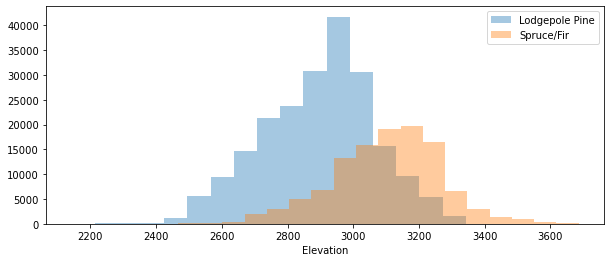

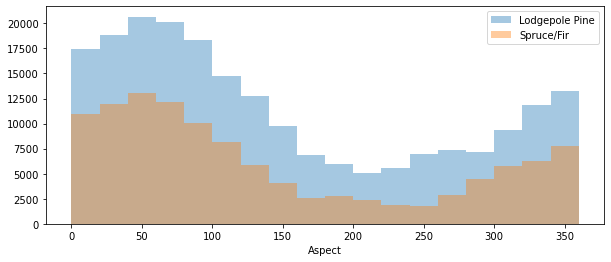

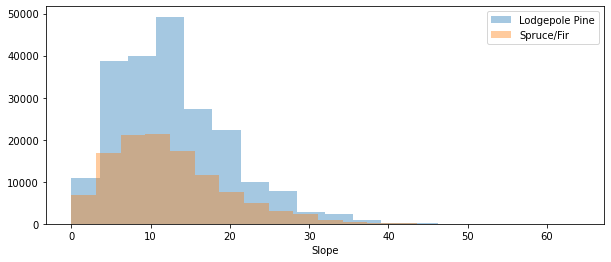

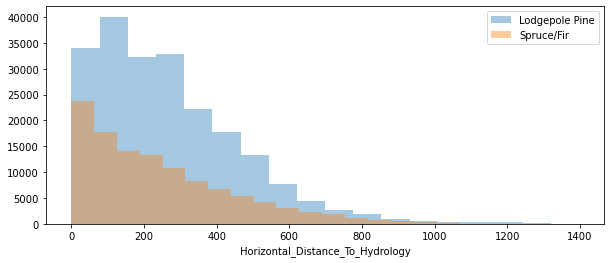

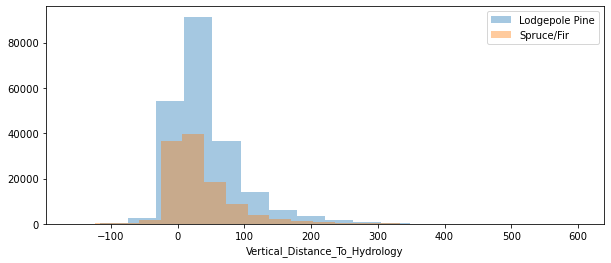

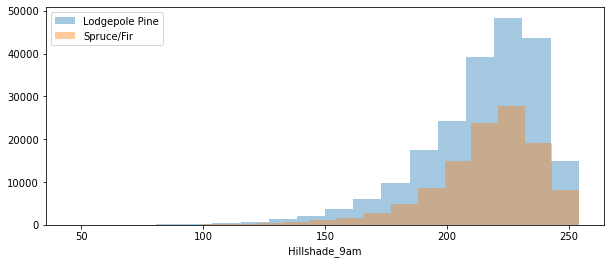

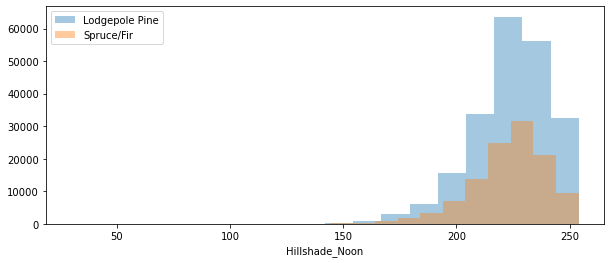

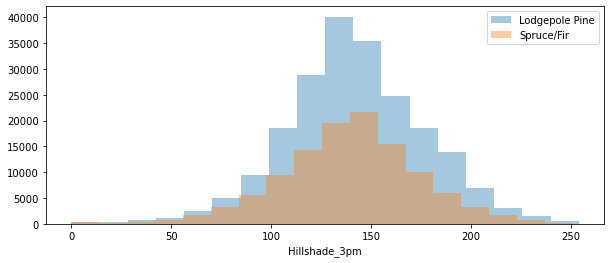

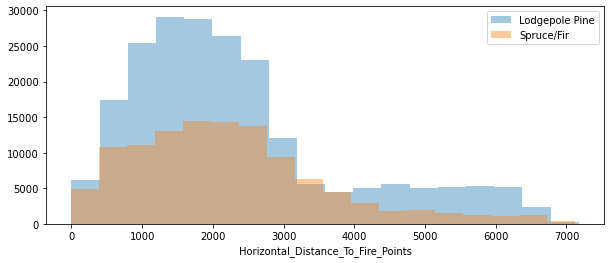

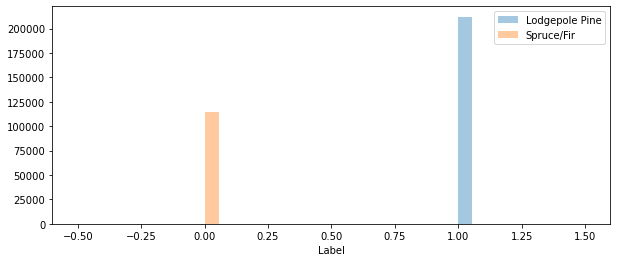

In [31]:
num_col=raw_df.select_dtypes('number').columns
for i in range(len(num_col)):
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10, 4))
    ax = sns.distplot(raw_df[raw_df['Label']==1][num_col[i]], bins=18, label = 'Lodgepole Pine', ax = axes, kde =False)
    ax = sns.distplot(raw_df[raw_df['Label']==0][num_col[i]], bins=18, label = 'Spruce/Fir', ax = axes, kde =False)
    ax.legend()

**Observations:**
* We generally have more entries classified as Lodgepole Pine than Spruce/Fir (roughly 1.6x)
* All our continuous variables have reasonable distributions (no suspicious outliers)
* The only feature with a distinctive impact on label is `Elevation`. Others seem to follow the classification spread

Let's do the same for categorical variables!


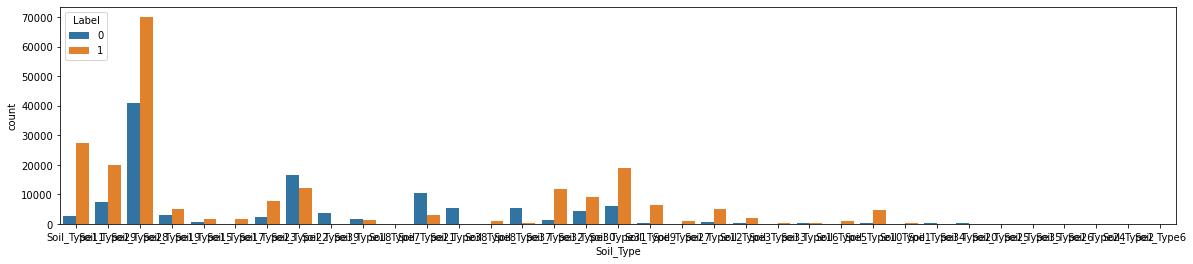

In [32]:
plt.figure(figsize=(20,4))
sns.countplot(data=raw_df, x='Soil_Type', hue='Label')
#plt.title('Group size')

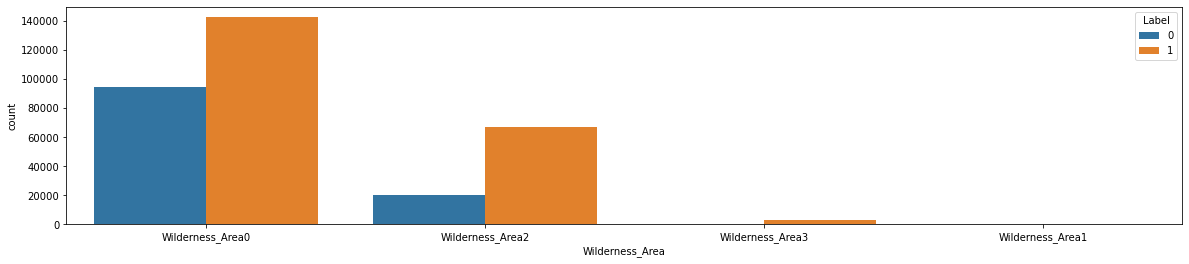

In [33]:
plt.figure(figsize=(20,4))
sns.countplot(data=raw_df, x='Wilderness_Area', hue='Label')
#plt.title('Group size')

**Observations:**
* Wilderness areas seem to generally follow the distribution that we expected from the classification labels, but already Wilderness_Area2 seems to be more highly skewed towards Label 1 - Lodgepole Pine
* Soil_Type offers an interesting mix where Label 0 is sometimes more favored than Label 1 - contrary to over overall distribution of labels!

# Pre-processing

In order to do any type of modeling, we need to first pre-process the data. Namely, we need to get dummy variables for the categorical variables.

We need to also separate our training set from our testing set.

In [38]:
# Use get_dummies to one-hot encode the categorical variables
df = pd.get_dummies(raw_df,prefix='', prefix_sep='')
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Label,...,Soil_Type39,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Wilderness_Area0,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3
0,2804,139,9,268,65,234,238,135,6121,1,...,0,0,0,0,0,0,1,0,0,0
1,2785,155,18,242,118,238,238,122,6211,1,...,0,0,0,0,0,0,1,0,0,0
2,2579,132,6,300,-15,230,237,140,6031,1,...,0,0,0,0,0,0,1,0,0,0
3,2886,151,11,371,26,234,240,136,4051,1,...,0,0,0,0,0,0,1,0,0,0
4,2742,134,22,150,69,248,224,92,6091,1,...,0,0,0,0,0,0,1,0,0,0


In [40]:
# Use train_test_split to divide the dataset into 80-20 training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(df.drop(["Label"], axis=1), df["Label"], 
                                                    test_size = 0.20, random_state = 42)

# Modeling

## Baseline: Logistic Regression

In order to establish a baseline, we can use Logistic Regression with all default settings. This will likely be an overfitted model, with issues regarding scales, but it is nonetheless a fast implementation that should allow us to benchmark our other models.

In [43]:
# trying Logistic Regression as a baseline
# Instantiate and fit model 
lr_clf = LogisticRegression(random_state = 42)
lr_clf.fit(X_train, y_train)

# make predictions for test data
y_pred = lr_clf.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = metrics.accuracy_score(y_test, predictions)
print("Baseline Logistic Regression accuracy: %.2f%%" % (accuracy * 100.0))

Baseline Logistic Regression accuracy: 77.90%


/Users/Varishth/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Random Forest

**A more logical model to implement is a Random Forest model. This is because we have a very large dataset, with varying scales, and therefore an ensemble of decision trees is likely a more effective approach**

In [46]:
# Instantiate model with all default RF classifier settings
rf_clf = RandomForestClassifier( random_state = 42)
# Train the model on training data
rf_clf.fit(X_train, y_train)
# performing predictions on the test dataset
y_pred = rf_clf.predict(X_test)
# using metrics module for accuracy calculation
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Untuned Random Forest accuracy: %.2f%%" % (accuracy * 100.0))

Untuned Random Forest accuracy: 93.50%


Even the untuned Random Forest perfomrs really well - giving us a new baseline to compare against! Before tuning the hyperparameters of the Random Forest, we can take a look at the features that are most important

No handles with labels found to put in legend.


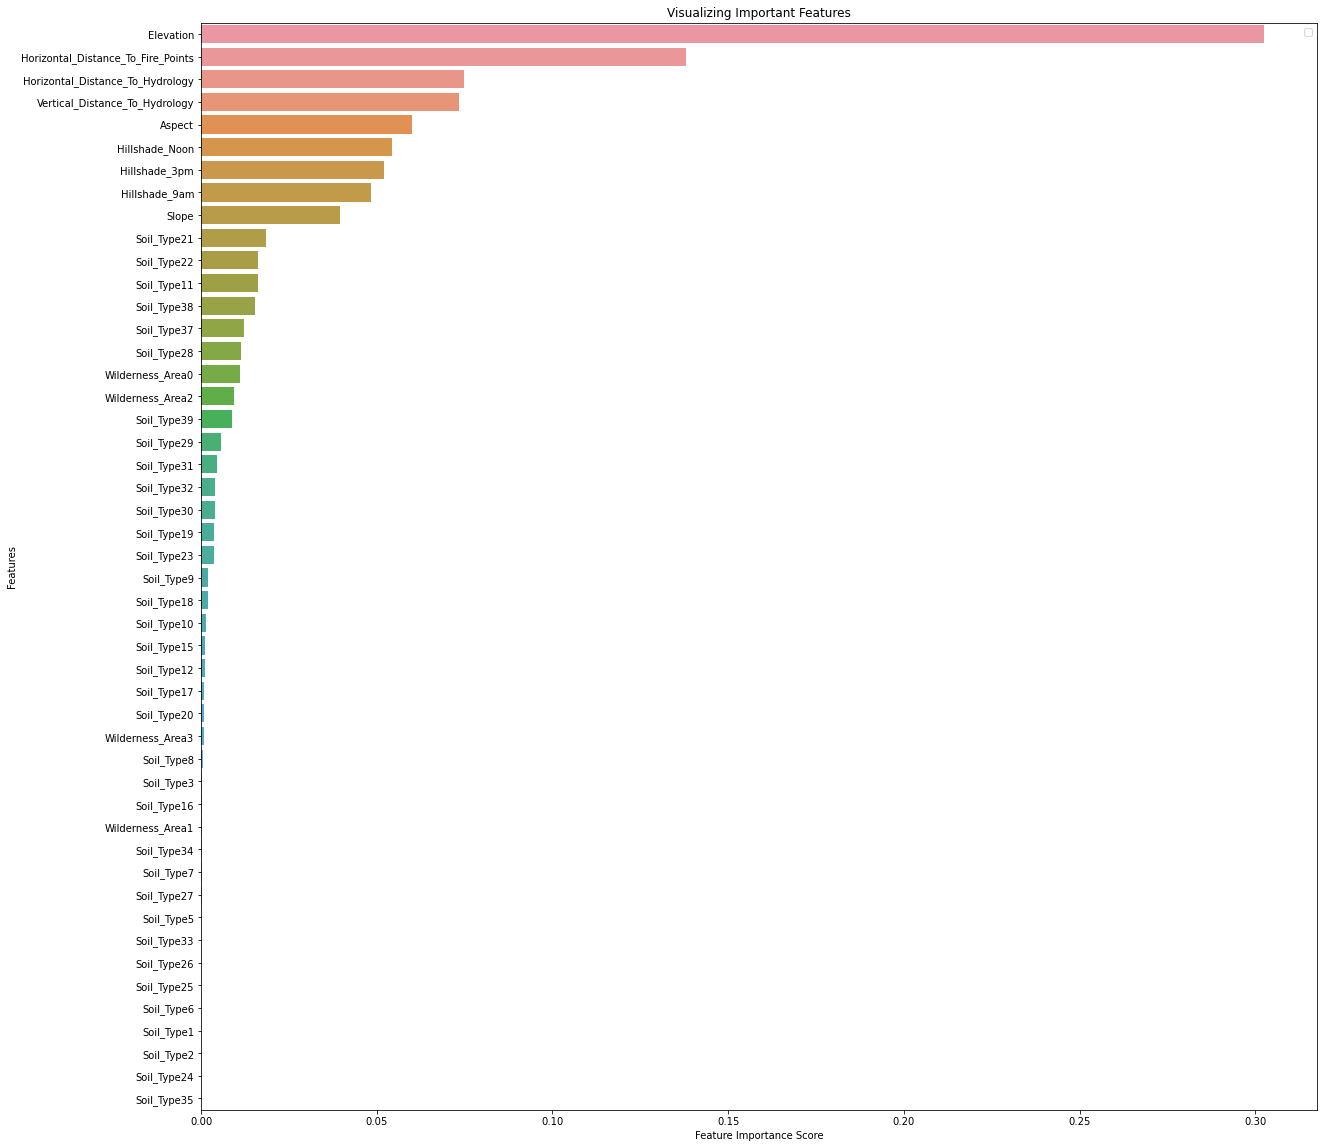

In [49]:
# Explore the feature importances from our trained Random Forest model
feature_imp = pd.Series(rf_clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)

# Creating a bar plot
plt.figure(figsize=(20,20))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

As we had initially hypothesised, `Elevation` indeed plays a large role in this prediction!

**What happens if we half our features to save on computation time?**

In [60]:
#Get top 20 features
best_features = feature_imp[:20].index


In [70]:
# create new df
df_simple = df[best_features]
df_simple["Label"] = df["Label"]
df_simple.head()

<ipython-input-70-519b10aa512a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simple["Label"] = df["Label"]


,Elevation,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Aspect,Hillshade_Noon,Hillshade_3pm,Hillshade_9am,Slope,Soil_Type21,...,Soil_Type11,Soil_Type38,Soil_Type37,Soil_Type28,Wilderness_Area0,Wilderness_Area2,Soil_Type39,Soil_Type29,Soil_Type31,Label
0,2804,6121,268,65,139,238,135,234,9,0,...,1,0,0,0,1,0,0,0,0,1
1,2785,6211,242,118,155,238,122,238,18,0,...,0,0,0,0,1,0,0,1,0,1
2,2579,6031,300,-15,132,237,140,230,6,0,...,0,0,0,1,1,0,0,0,0,1
3,2886,4051,371,26,151,240,136,234,11,0,...,0,0,0,0,1,0,0,1,0,1
4,2742,6091,150,69,134,224,92,248,22,0,...,0,0,0,0,1,0,0,1,0,1


Let's re-split and re-train our random forest

In [73]:
# Use train_test_split to divide the dataset into 80-20 training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(df_simple.drop(["Label"], axis=1), df_simple["Label"], 
                                                    test_size = 0.20, random_state = 42)

In [74]:
# Instantiate model with all default RF classifier settings
rf_clf = RandomForestClassifier( random_state = 42)
# Train the model on training data
rf_clf.fit(X_train, y_train)
# performing predictions on the test dataset
y_pred = rf_clf.predict(X_test)
# using metrics module for accuracy calculation
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Simplified Random Forest accuracy: %.2f%%" % (accuracy * 100.0))

Simplified Random Forest accuracy: 93.85%


We not only gained in performance time, but also in performance accuracy!

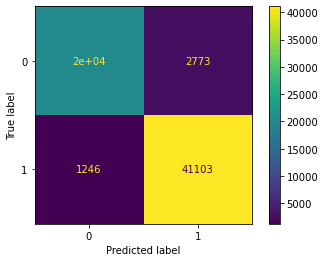

In [77]:
# Let's plot a confusion matrix to see what we predicting best
plot_confusion_matrix(rf_clf, X_test, y_test)  
plt.show()